**Name:** SIVAKUMAR Srinivas

**EID:** ssivakuma2

# CS4487 - Tutorial 8
## Non-Linear Dimensionality Reduction and Face Recognition

In this tutorial you will use non-linear dimensionality reduction on face images, and then train a classifier for face recognition.  You will then use manifold embedding to visualize the data.

First we need to initialize Python.  Run the below cell.

In [12]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
random.seed(100)
rbow = plt.get_cmap('rainbow')
from sklearn.model_selection import ParameterGrid

## Loading Data and Pre-processing
We first need to load the images.  We will use the same dataset as Tutorial 7. Download `olivetti_py3.pkz` from Canvas, and place it in in the same directory as this ipynb file.  _DO NOT UNZIP IT_.  Then run the following cell to load the images.

In [2]:
oli = datasets.fetch_olivetti_faces(data_home="./")
X = oli.data
Y = oli.target
img = oli.images
imgsize = oli.images[0].shape

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to ./


Each image is a 64x64 array of pixel values, resulting in a 4096 dimensional vector.  Run the below code to show all the images!

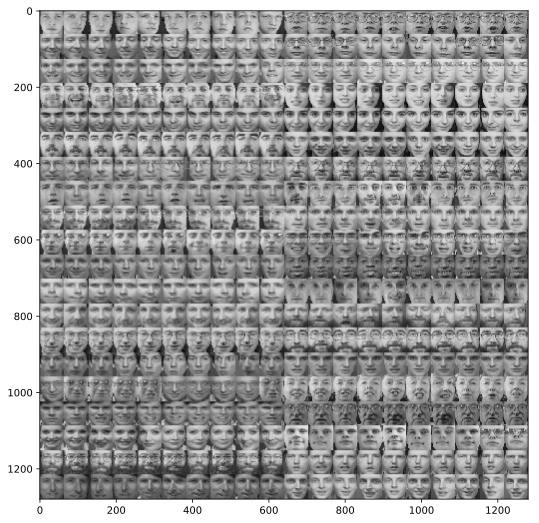

In [3]:
tmp = []
for i in range(0,400,20):
    tmp.append( hstack(img[i:i+20]) )
allimg = vstack(tmp)
plt.figure(figsize=(9,9))
plt.imshow(allimg, cmap='gray', interpolation='nearest')
plt.show()

Each person is considered as one class, and there are 10 images for each class.  In total there are 40 classes (people).  The data is already vectorized and put into the matrix `X`. Now we split the data into training and testing sets.

In [4]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print(trainX.shape)
print(testX.shape)

(320, 4096)
(80, 4096)


# Non-Linear Dimensionality Reduction - KPCA
The dimension of the data is too large (4096) so learning classifiers will take a long time.  Instead, our strategy is to use KPCA to reduce the dimension first and then use the KPCA weights as the representation for each image.  Run KPCA on the data using 10 principal components.  Use the RBF kernel with gamma=0.001.

In [5]:
### INSERT YOUR CODE HERE

In [6]:
kpca = decomposition.KernelPCA(n_components=10, kernel='rbf', gamma=0.001)
trainW = kpca.fit_transform(trainX)
testW = kpca.transform(testX)

The below function will plot the basis vectors of KPCA. Run the next 2 cells to view the PCs.  The kernel PCs are a combination of similarities to points in the training set.  The PCs are visualized by showing the top 5 positive and negative training examples, along with their coefficient $\alpha_i$.

In [7]:
def plot_kbasis(model, imgsize, X):
    KK = model.n_components
    alphas = model.alphas_.T
    minmax = 5
    
    py = KK
    px = minmax*2
    for i in range(KK):
        # sort alphas
        inds = argsort(alphas[i,:])

        myi = r_[arange(-1,-minmax-1,-1), arange(minmax-1,-1,-1)]
        myinds = inds[myi]
        
        for j,jj in enumerate(myinds):
            plt.subplot(py,px,(j+1)+i*px)
            plt.imshow(X[jj,:].reshape(imgsize), interpolation='nearest')
            plt.gray()
            if alphas[i,jj]<0:
                mycol = 'b'
            else:
                mycol = 'r'
            plt.title("{:.3f}".format(alphas[i,jj]), fontsize=7, color=mycol)
            if (j==0):
                plt.ylabel('PC' + str(i+1))
            plt.xticks([])
            plt.yticks([])

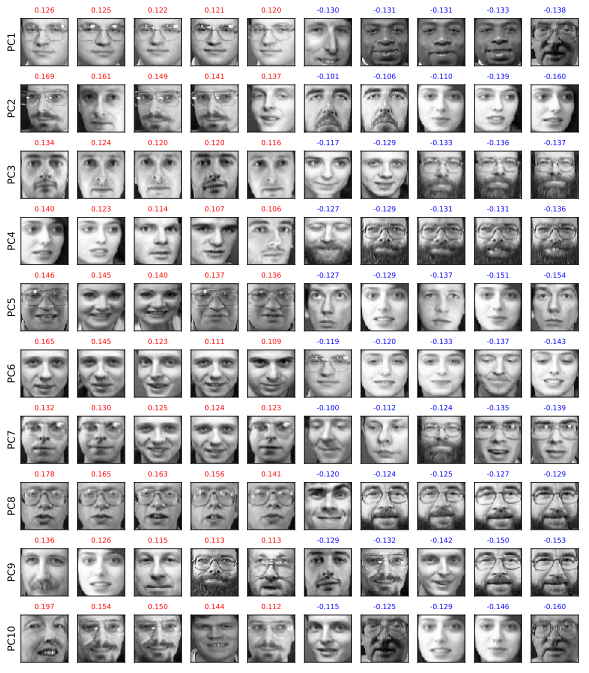

In [8]:
# run the function
plt.figure(figsize=(10,12))
plot_kbasis(kpca, imgsize, trainX)

_What is the interpretation for the KPCA basis?  What kind of faces do some of the PCs prefer?_
- PC1 differentiates between lighter and darker pictures/faces. 
- PC4 and PC8 prefer clean shaven faces, negative value for bearded ones.

### Face Recognition
Now train a _linear_ classifier to do the face recognition.  Use the calculated KPCA representation as the new set of inputs.  Use cross-validation to set the hyperparameters of the classifier.  You do not need to do cross-validation for the number of components or kernel hyperparameters.  Calculate the average training and testing accuracies.  Remember to transform the test data into the KPCA representation too!

**NOTE**: It is **NOT** recommended to use `svm.SVC` for the training.  This is because the default SVC implements 1-vs-1 multi-class classification, which means it will calculate 40x39=1560 classifiers!  All other classifier should be fine since they do 1-vs-all multi-class classification, e.g., LogisticRegressionCV, LinearSVC, etc.  If you want to use svm.SVC, make sure to use the OneVsRestClassifier as shown in Lecture 3.

In [9]:
### INSERT YOUR CODE HERE

In [10]:
### INSERT YOUR CODE HERE
logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5, n_jobs=-1, verbose = 1)
logreg.fit(trainW, trainY)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.2s finished


LogisticRegressionCV(Cs=array([1.00000e-04, 2.63665e-04, 6.95193e-04, 1.83298e-03, 4.83293e-03,
       1.27427e-02, 3.35982e-02, 8.85867e-02, 2.33572e-01, 6.15848e-01,
       1.62378e+00, 4.28133e+00, 1.12884e+01, 2.97635e+01, 7.84760e+01,
       2.06914e+02, 5.45559e+02, 1.43845e+03, 3.79269e+03, 1.00000e+04]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=1)

In [11]:
predYtest  = logreg.predict(testW)
acc = metrics.accuracy_score(testY,predYtest)
print('Accuracy = ',acc)

Accuracy =  0.725


### Finding the best kernel and best number of components
Now try different kernels (poly, RBF, etc), kernel parameters, and number of components to get the best test accuracy.  Train a classifier for each one and see which dimension gives the best testing accuracy.  Make a plots of number of components vs. test accuracy.

In [ ]:
### INSERT YOUR CODE HERE

In [50]:
gammas = [0.0001, 0.0005, 0.001, 0.005, 0.01]
ncs = [5, 10, 15, 20, 25, 30]
param_grid = {'gamma':gammas,'nc':ncs};
trainacc = zeros((len(gammas), len(ncs)))
testacc  = zeros((len(gammas), len(ncs)))#storing the results in a 2d array to better display the results

for i,elem in enumerate(list(ParameterGrid(param_grid))):
    print("gamma = ",str(elem['gamma']),"nc = ",str(elem['nc']))
    kpca = decomposition.KernelPCA(n_components=elem['nc'], kernel='rbf', gamma=elem['gamma'])
    trainW = kpca.fit_transform(trainX)
    testW  = kpca.transform(testX)

    logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,10), cv=5)
    logreg.fit(trainW, trainY)

    # predict from the model
    predYtrain = logreg.predict(trainW)
    predYtest  = logreg.predict(testW)

    # calculate accuracy
    trainacc[int(i/6),int(i%6)] = metrics.accuracy_score(trainY, predYtrain)
    testacc[int(i/6),int(i%6)]  = metrics.accuracy_score(testY, predYtest)
    
    print('train accuracy =',trainacc[int(i/6),int(i%6)],'test accuracy =',testacc[int(i/6),int(i%6)])



gamma =  0.0001 nc =  5
train accuracy = 0.378125 test accuracy = 0.3625
gamma =  0.0001 nc =  10
train accuracy = 0.896875 test accuracy = 0.7
gamma =  0.0001 nc =  15
train accuracy = 0.98125 test accuracy = 0.825
gamma =  0.0001 nc =  20
train accuracy = 1.0 test accuracy = 0.925
gamma =  0.0001 nc =  25
train accuracy = 1.0 test accuracy = 0.9375
gamma =  0.0001 nc =  30
train accuracy = 1.0 test accuracy = 0.9375
gamma =  0.0005 nc =  5
train accuracy = 0.4 test accuracy = 0.35
gamma =  0.0005 nc =  10
train accuracy = 0.9 test accuracy = 0.725
gamma =  0.0005 nc =  15
train accuracy = 0.996875 test accuracy = 0.8375
gamma =  0.0005 nc =  20
train accuracy = 1.0 test accuracy = 0.9125
gamma =  0.0005 nc =  25
train accuracy = 1.0 test accuracy = 0.9375
gamma =  0.0005 nc =  30
train accuracy = 1.0 test accuracy = 0.95
gamma =  0.001 nc =  5
train accuracy = 0.421875 test accuracy = 0.3625
gamma =  0.001 nc =  10
train accuracy = 0.896875 test accuracy = 0.725
gamma =  0.001 nc =  

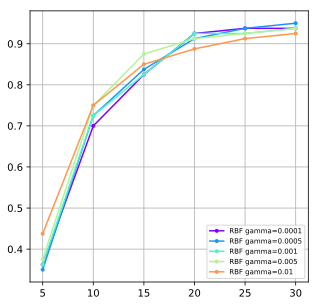

In [51]:
plt.figure(figsize=(5,5))
for i,gamma in enumerate(gammas):
    plt.plot(ncs, testacc[i,:], '.-', color=rbow(float(i)/len(gammas)), label="RBF gamma="+str(gamma))
plt.legend(loc="best", fontsize=7)
plt.grid(True)

In [52]:
degrees = [1,2,3,4,5]
ncs = [5, 10, 15, 20, 25, 30]
param_grid = {'degree':degrees,'nc':ncs};
trainaccPoly = zeros((len(gammas), len(ncs)))
testaccPoly  = zeros((len(gammas), len(ncs)))#storing the results in a 2d array to better display the results

for i,elem in enumerate(list(ParameterGrid(param_grid))):
    print("degree = ",str(elem['degree']),"nc = ",str(elem['nc']))
    kpca = decomposition.KernelPCA(n_components=elem['nc'], kernel='poly', degree=elem['degree'])
    trainW = kpca.fit_transform(trainX)
    testW  = kpca.transform(testX)

    logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,10), cv=5)
    logreg.fit(trainW, trainY)

    # predict from the model
    predYtrain = logreg.predict(trainW)
    predYtest  = logreg.predict(testW)

    # calculate accuracy
    trainaccPoly[int(i/6),int(i%6)] = metrics.accuracy_score(trainY, predYtrain)
    testaccPoly[int(i/6),int(i%6)]  = metrics.accuracy_score(testY, predYtest)
    
    print('train accuracy =',trainaccPoly[int(i/6),int(i%6)],'test accuracy =',testaccPoly[int(i/6),int(i%6)])



degree =  1 nc =  5
train accuracy = 0.35625 test accuracy = 0.3125
degree =  1 nc =  10
train accuracy = 0.9 test accuracy = 0.7125
degree =  1 nc =  15
train accuracy = 0.9625 test accuracy = 0.8125
degree =  1 nc =  20
train accuracy = 1.0 test accuracy = 0.925
degree =  1 nc =  25
train accuracy = 1.0 test accuracy = 0.925
degree =  1 nc =  30
train accuracy = 1.0 test accuracy = 0.925
degree =  2 nc =  5
train accuracy = 0.371875 test accuracy = 0.3375
degree =  2 nc =  10
train accuracy = 0.896875 test accuracy = 0.725
degree =  2 nc =  15
train accuracy = 0.9875 test accuracy = 0.8375
degree =  2 nc =  20
train accuracy = 1.0 test accuracy = 0.9125
degree =  2 nc =  25
train accuracy = 1.0 test accuracy = 0.925
degree =  2 nc =  30
train accuracy = 1.0 test accuracy = 0.9375
degree =  3 nc =  5
train accuracy = 0.403125 test accuracy = 0.3625
degree =  3 nc =  10
train accuracy = 0.921875 test accuracy = 0.725
degree =  3 nc =  15
train accuracy = 0.99375 test accuracy = 0.8625


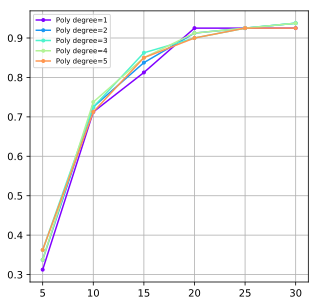

In [53]:
plt.figure(figsize=(5,5))
for i,deg in enumerate(degrees):
    plt.plot(ncs, testaccPoly[i,:], '.-', color=rbow(float(i)/len(degrees)), label="Poly degree="+str(deg))
plt.legend(loc="best", fontsize=7)
plt.grid(True)

_What is the best kernel and number of components?  View the prototypes for each compenent to see what they look like_
- RBF kernel with around 30 components

In [55]:
i = unravel_index(argmax(testacc), testacc.shape)
print(i)
print(testacc[i])
gamma = gammas[i[0]]
print(gamma)

(1, 5)
0.95
0.0005


In [57]:
kpca = decomposition.KernelPCA(n_components=30, kernel='rbf', gamma=gamma)
trainW = kpca.fit_transform(trainX)
testW  = kpca.transform(testX)

In [60]:
plt.figure(figsize=(10,34))
plot_kbasis(kpca, imgsize, trainX)

# Manifold embedding
Now you will use manifold embedding to visualize the dataset.
Use various methods to embed the data into 2 dimensions.  Use the below function to plot the low-dimensional data. **Note:** use the whole dataset `X` to do the embedding.

In [61]:
def plot_embedding(X, Y, title=None):
    # X is the low-dim data
    zoomfact = 0.25  # change this to make images bigger/smaller
    
    x_min, x_max = amin(X, 0), amax(X, 0)
    X = (X - x_min) / (x_max - x_min)
    ax = plt.gca()

    plt.scatter(X[:,0], X[:,1], c=Y, cmap=rbow, edgecolor="")
    
    if hasattr(matplotlib.offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = array([[1., 1.]])  # just something big
        for i in range(img.shape[0]):
            dist = sum((X[i] - shown_images) ** 2, 1)
            if min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = r_[shown_images, [X[i]]]
            imagebox = matplotlib.offsetbox.AnnotationBbox(
                matplotlib.offsetbox.OffsetImage(img[i], 
                    zoom=zoomfact, 
                    cmap=plt.cm.gray), X[i], pad=0.02)
            imagebox.patch.set_edgecolor(rbow(Y[i]/max(Y)))
            imagebox.patch.set_linewidth(2)
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [ ]:
### INSERT YOUR CODE HERE

In [65]:
n_neighbors = 15

X_pca = decomposition.PCA(n_components=2).fit_transform(X)
X_iso = manifold.Isomap(n_neighbors, n_components=2).fit_transform(X)
X_lle = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2).fit_transform(X)
X_hlle = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2, method='hessian').fit_transform(X)
X_ltsa = manifold.LocallyLinearEmbedding(n_neighbors, n_components=2, method='ltsa').fit_transform(X)
X_mds = manifold.MDS(n_components=2, n_init=1, max_iter=100).fit_transform(X)
X_se = manifold.SpectralEmbedding(n_components=2, random_state=0, eigen_solver="arpack").fit_transform(X)
X_tsne = manifold.TSNE(n_components=2, init='pca', random_state=0).fit_transform(X)

D:\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


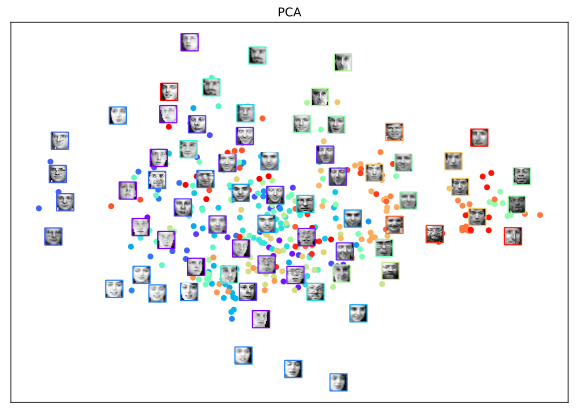

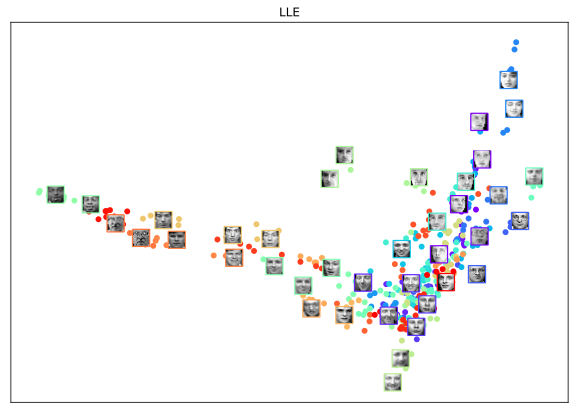

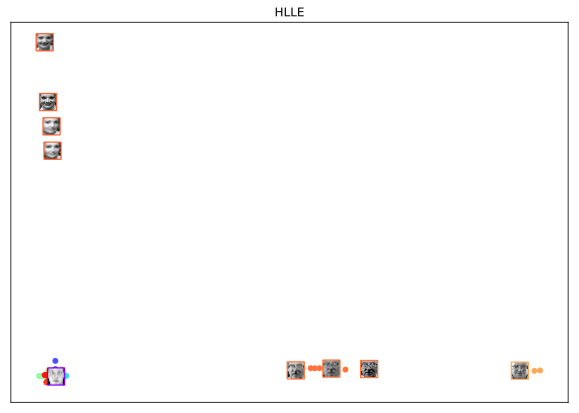

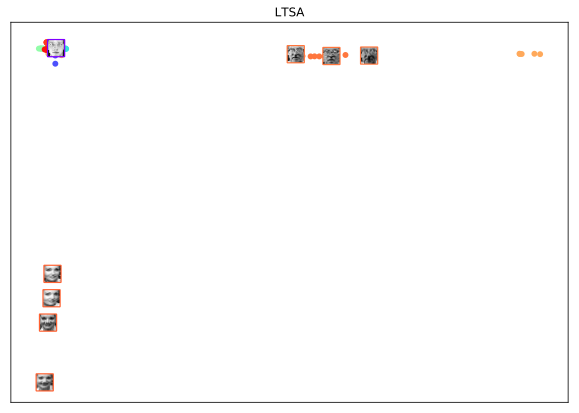

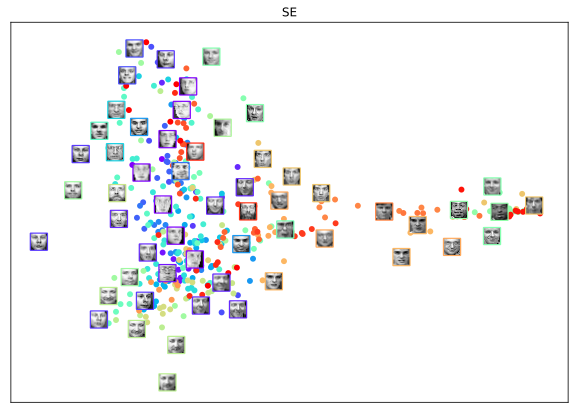

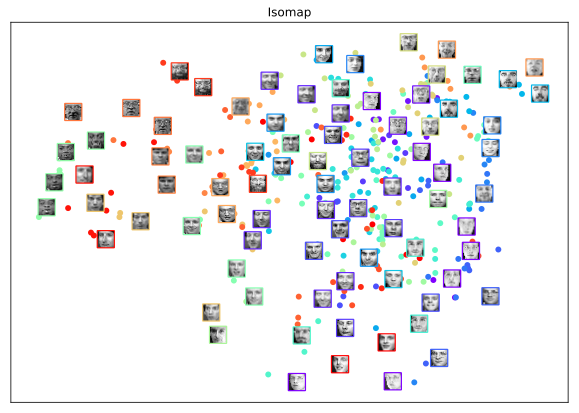

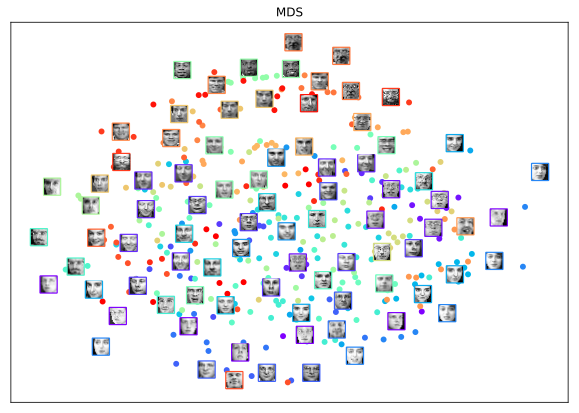

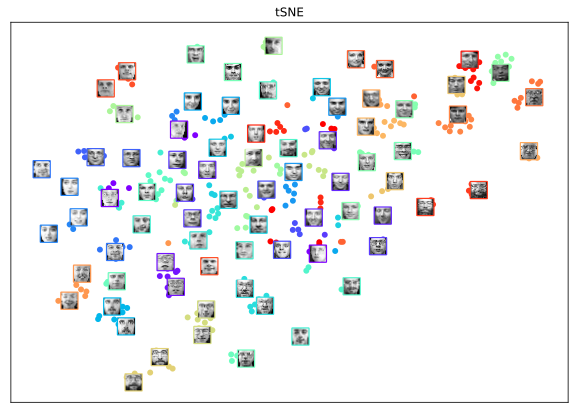

In [69]:
Xall = [X_pca, X_lle, X_hlle, X_ltsa, X_se, X_iso, X_mds, X_tsne]
titles = ["PCA", "LLE", "HLLE", 'LTSA', "SE", "Isomap", "MDS", "tSNE"]

for i in range(len(Xall)):
    plt.figure(figsize=(10,7))
    plot_embedding(Xall[i],Y,titles[i])

_Which embedding looks the best in terms of preserving structure of the data (similarity between images)?_
- tSNE and isomap look the best. Points of the same color appear closer together.